# 서울 지하철 유동인구·사고 분석

2020–2024년 서울교통공사 공공데이터를 활용하여 **시간대별·역별 유동인구**와 **사고유형별 역별 사고 건수**를 분석하고, 두 지표를 결합해 **역별 사고비율**을 계산합니다.

순서는 다음과 같습니다:
1. 라이브러리 및 한글 폰트 설정
2. 전처리 함수 정의
3. 데이터 불러오기
4. 연도별 시간대 평균 유동인구 분석·시각화
5. 사고유형별,시간대별별 역별 사고 건수 집계 및 시각화
6. 사고비율(사고건수/평균유동인구) 시각화
7. 소방시설

## 라이브러리 및 한글 폰트 설정

In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import platform

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':  # macOS
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False


## 역명 전처리 함수 정의

In [18]:

def normalize_station(name: str) -> str:
    """괄호 및 '역' 제거 후 공백 정리"""
    name = str(name)
    name = re.sub(r'\(.*?\)', '', name)  # 괄호 내용 제거
    return name.replace('역', '').strip()


## 데이터 불러오기

In [15]:

# 연도별 시간대 승·하차 데이터 (경로는 노트북과 같은 폴더에 위치한다고 가정)
yearly_files = {
    2020: "서울교통공사_역별 시간대별 승하차인원(20.1~20.12).csv",
    2021: "서울교통공사_역별 시간대별 승하차인원(21.1~21.12).csv",
    2022: "서울교통공사_역별 시간대별 승하차인원(22.1~22.12).csv",
    2023: "서울교통공사_역별 시간대별 승하차인원(23.1~23.12).csv",
    2024: "서울교통공사_역별 시간대별 승하차인원(24.1~24.12).csv"
}

# 사고 데이터
accident_df = pd.read_csv("서울교통공사_최근 5년 지하철 사고 현황_20250310.csv", encoding="cp949")

machine_path = "서울교통공사_기계시설정보_20250310.csv"
arch_path = "서울교통공사_역사건축정보_20250310.csv"

# 인코딩 주의: cp949 사용
machine_df = pd.read_csv(machine_path, encoding='cp949')
arch_df = pd.read_csv(arch_path, encoding='cp949')

In [16]:
import pandas as pd



# 소방 관련 설비만 필터링
fire_eq = machine_df[machine_df["대분류"].str.contains("소방") | machine_df["중분류"].str.contains("소방")]

# 호선별 소방설비 수량 집계
fire_by_line = fire_eq.groupby("호선")["수량"].sum().reset_index().rename(columns={"수량": "소방설비_총수량"})

# 호선 데이터 타입 통일 (예: '1호선' → '1')
fire_by_line["호선"] = fire_by_line["호선"].str.replace("호선", "").str.strip()

# 건축 정보 데이터에서 호선별 총면적 합산
arch_df["호선"] = arch_df["호선"].astype(str)
area_by_line = arch_df.groupby("호선")["면적"].sum().reset_index().rename(columns={"면적": "총면적"})

# 두 데이터 병합
merged = pd.merge(fire_by_line, area_by_line, on="호선", how="inner")

# 소방설비 밀도 계산 (㎡당 개수)
merged["소방설비_밀도(개/㎡)"] = merged["소방설비_총수량"] / merged["총면적"]

# 결과 출력
merged


,호선,소방설비_총수량,총면적,소방설비_밀도(개/㎡)
0,1,10789,90719.99000,0.118926
1,2,49558,379129.76000,0.130715
2,3,35072,330745.49400,0.106039
3,4,29586,217759.26000,0.135866
4,5,79043,515048.87000,0.153467
5,6,42838,338618.73455,0.126508
6,7,52987,420947.07000,0.125876
7,8,18695,127817.29000,0.146263


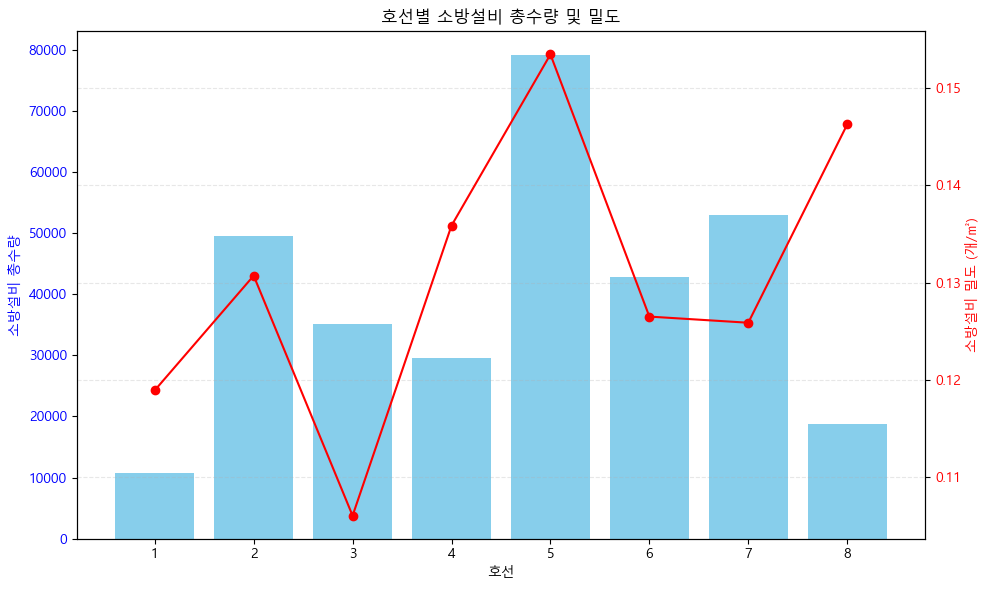

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import platform

# 시스템별 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':  # macOS
    plt.rc('font', family='AppleGothic')
else:  # Linux
    plt.rc('font', family='NanumGothic')

plt.rc('axes', unicode_minus=False)

# 이미 계산된 merged DataFrame 사용
# merged = ... (호선, 소방설비_총수량, 소방설비_밀도(개/㎡) 포함)

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 막대그래프: 소방설비 총수량
ax1.bar(merged["호선"], merged["소방설비_총수량"], color='skyblue')
ax1.set_xlabel("호선")
ax1.set_ylabel("소방설비 총수량", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 꺾은선그래프: 밀도
ax2 = ax1.twinx()
ax2.plot(merged["호선"], merged["소방설비_밀도(개/㎡)"], color='red', marker='o')
ax2.set_ylabel("소방설비 밀도 (개/㎡)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("호선별 소방설비 총수량 및 밀도")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
